<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/21.00.Aula-Modelo_individual_infeccao_e_recuperacao.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- O cenário da cidade do Rio de Janeiro](20.00.Aula-Cenario_Rio.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 

---


# Modelo individual: incluindo a fase de exposição

- A implementação que fizemos até agora é baseado nos compartimentos SIR, com um suscetível indo direto para uma única fase infecciosa.

- Mas o modelo evolui segundo uma versão individual do SEIR.

- Vamos, então, analisar a fase de exposição do modelo individual.

- E analisar, também, certos aspectos da fase infecciosa.

In [2]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [3]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming

In [4]:
sns.set_style("darkgrid")

In [5]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 02/Jun/2020


## Fontes

- O artigo [Halloran et al (2008)](#Referências) analisa o resultado das pesquisas de três grupos:

    - Imperial College and the University of Pittsburgh **(Imperial/Pitt)**.

    - University of Washington and Fred Hutchinson Cancer Research Center in Seattle and the Los Alamos National Laboratories **(UW/LANL)**.

    - Virginia Bioinformatics Institute of the Virginia Polytechnical Institute and State University **(VBI)**.

- A diferença principal entre eles está nos tipos de redes considerados, além das particularidades das diferentes regiões estudadas.

- Até o momento, temos estudado os artigos associados ao grupo do Imperial/Pitt. 

- Mas a leitura dos outros artigos e dos materiais complementares correspondentes ajudam no entendimento de alguns pontos obscuros nos artigos relacionados ao modelo do Imperial/Pitt.

- Em particular, vamos estudar os artigos [Germann et al (2006)](#Referências) e [Longinit et al (2005)](#Referências), relacionados ao grupo UW/LANL.

- O artigo citado em [Halloran et al (2008)](#Referências) sobre o grupo VBI não foi encontrado, mas a tese de [Lewis (2011)](#Referências) e um outro artigo [Lewis et al (2013)](#Referências) parecem tratar do mesmo modelo.

## O processo de infecção e suas fases

### Imperial/Pitt

- O [relatório do Imperial College](#Referências) descreve as fases de infecção do covid-19 como tendo tempos bem definidos e iguais para todos os indivíduos, mas os valores "quebrados" (os passos são em múltiplos de 0.25) sugerem que são distribuições:

> *We assumed an incubation period of 5.1 days. Infectiousness is assumed to occur from 12 hours prior to the onset of symptoms for those that are symptomatic and from 4.6 days after infection in those that are asymptomatic with an infectiousness profile over time that results in a 6.5-day mean generation time.*

- Já o seu artigo de referência sobre Influenza [Ferguson et al (2005)](#Referências) considera que o período de incubação da população segue uma determinada distribuição:

> *[...] the incubation period (time from infection to the start of symptoms) distribution for human influenza [...] given by a right-shifted Weibull distribution with a fixed offset of 0.5 days, power parameter 2.21 (95% CI: 1.36-3.37) and scale parameter 1.10 (95% CI: 0.83-1.42) – giving a mean incubation period of 1.48 days and standard deviation of 0.47 days.*

- O artigo seguinte [Ferguson et al (2006)](#Referências) contém, em particular, a seguinte figura sobre o período de incubação e o grau de contágio de uma pessoa infectada:


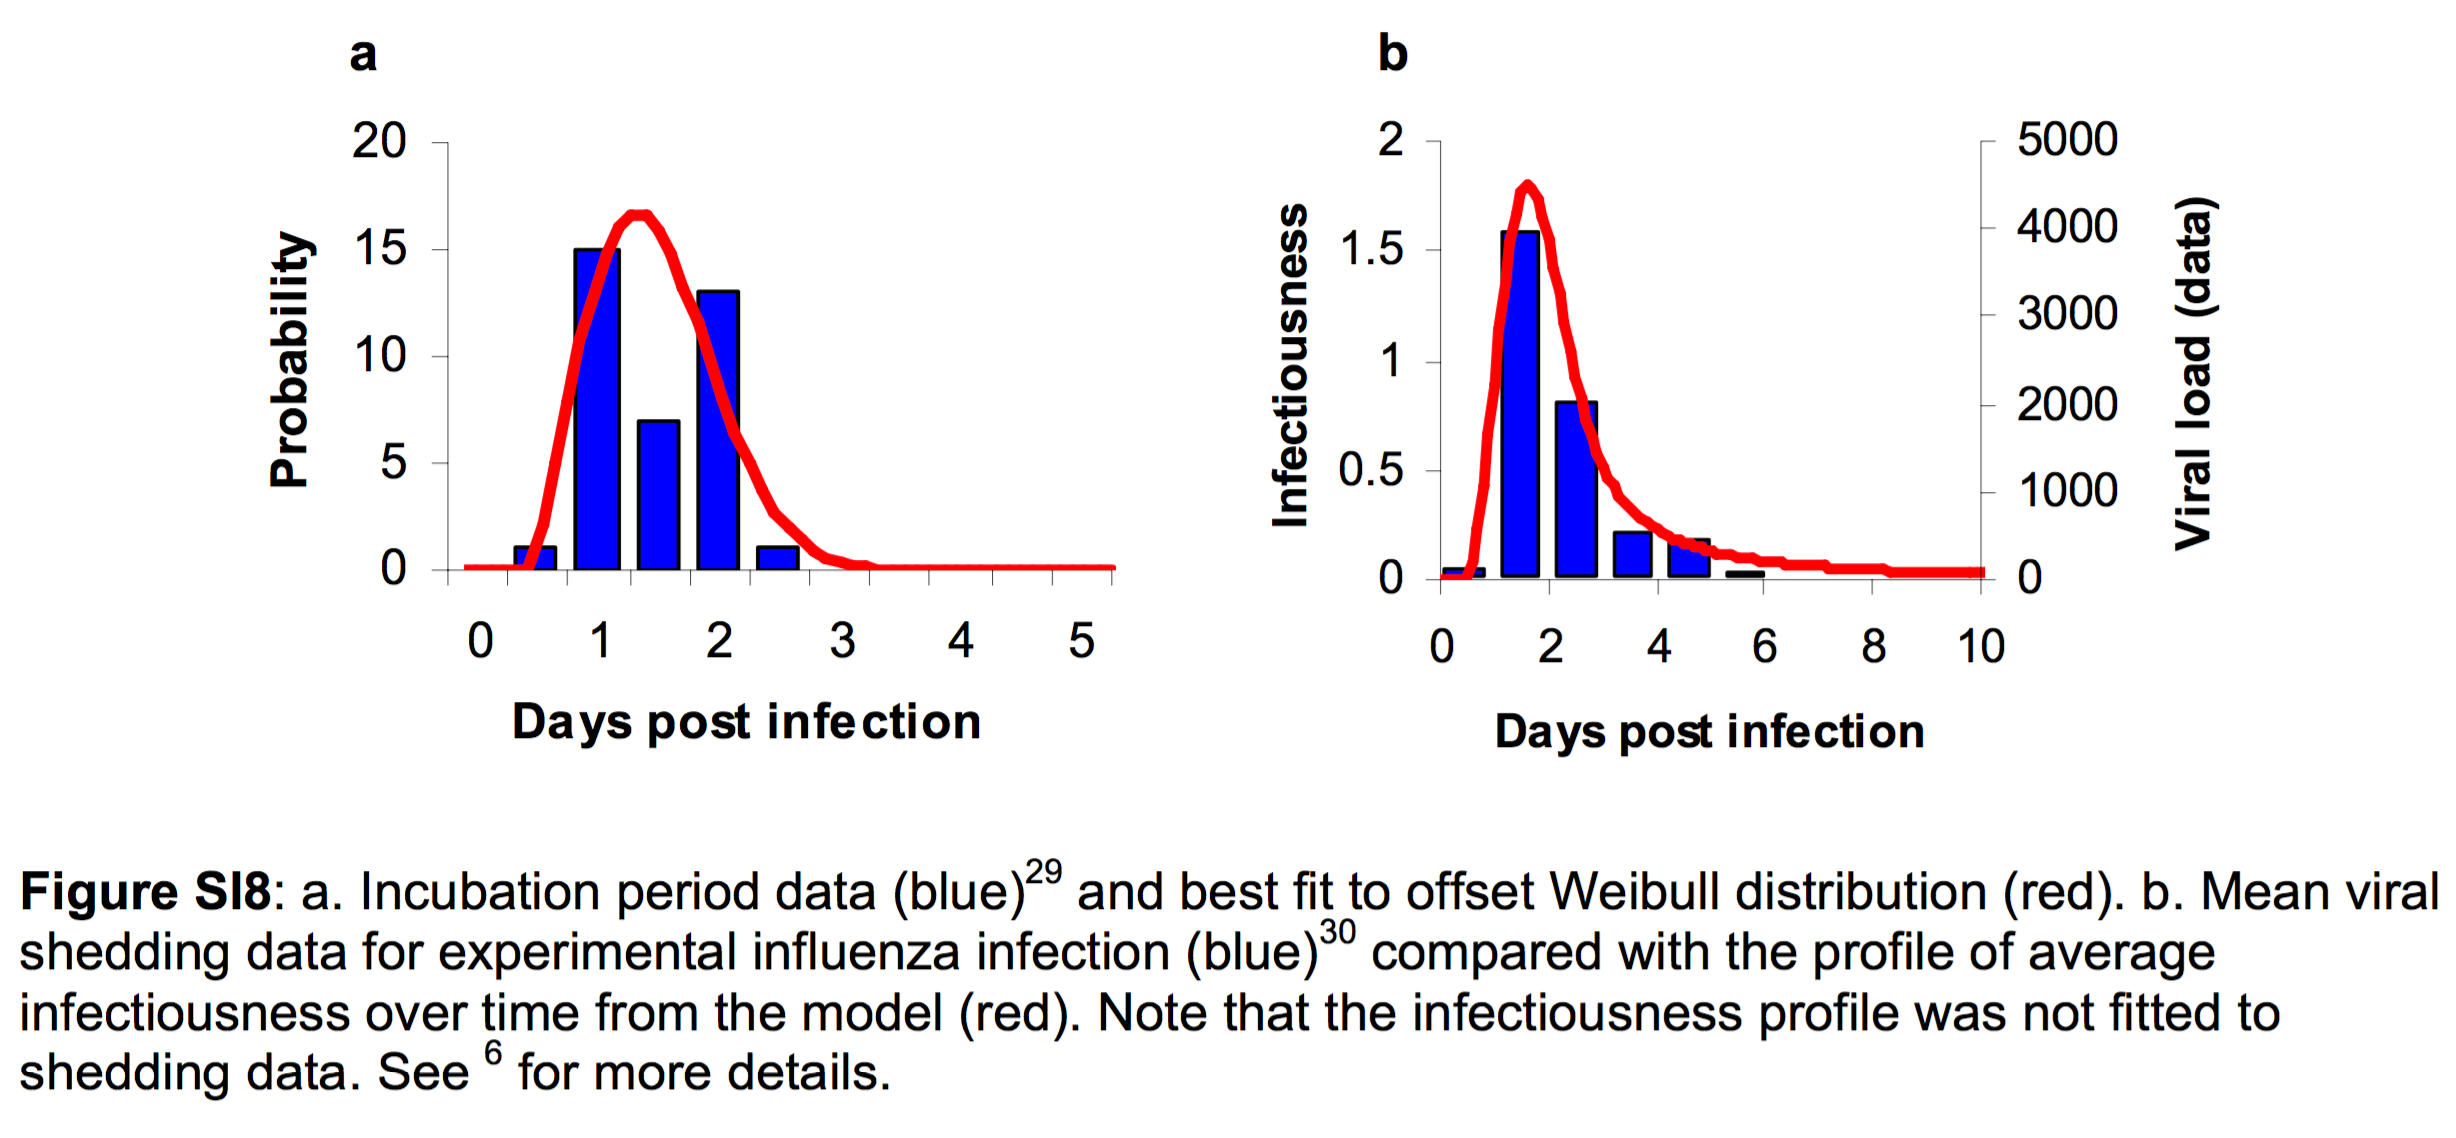

In [10]:
Image(filename=os.path.join('..', 'input', 'modelos_individuais',
                            '41586_2006_BFnature04795_MOESM28_ESM_FigureS18.png'), width=800)

### UW/LANL

- O [texto de apoio](#References) do artigo [Germann et al (2006)](#References), mais precisamente a seção **Disease natural history**, nas páginas 3 e 4, considera tempos baseados em distribuições discretas, tanto para o período de incubação quanto para o de infecção:

> *The main points are that the latent, incubation,
and contagious period durations are each sampled from discrete distributions, with mean periods of 1.2, 1.9, and 4.1 days, respectively.*

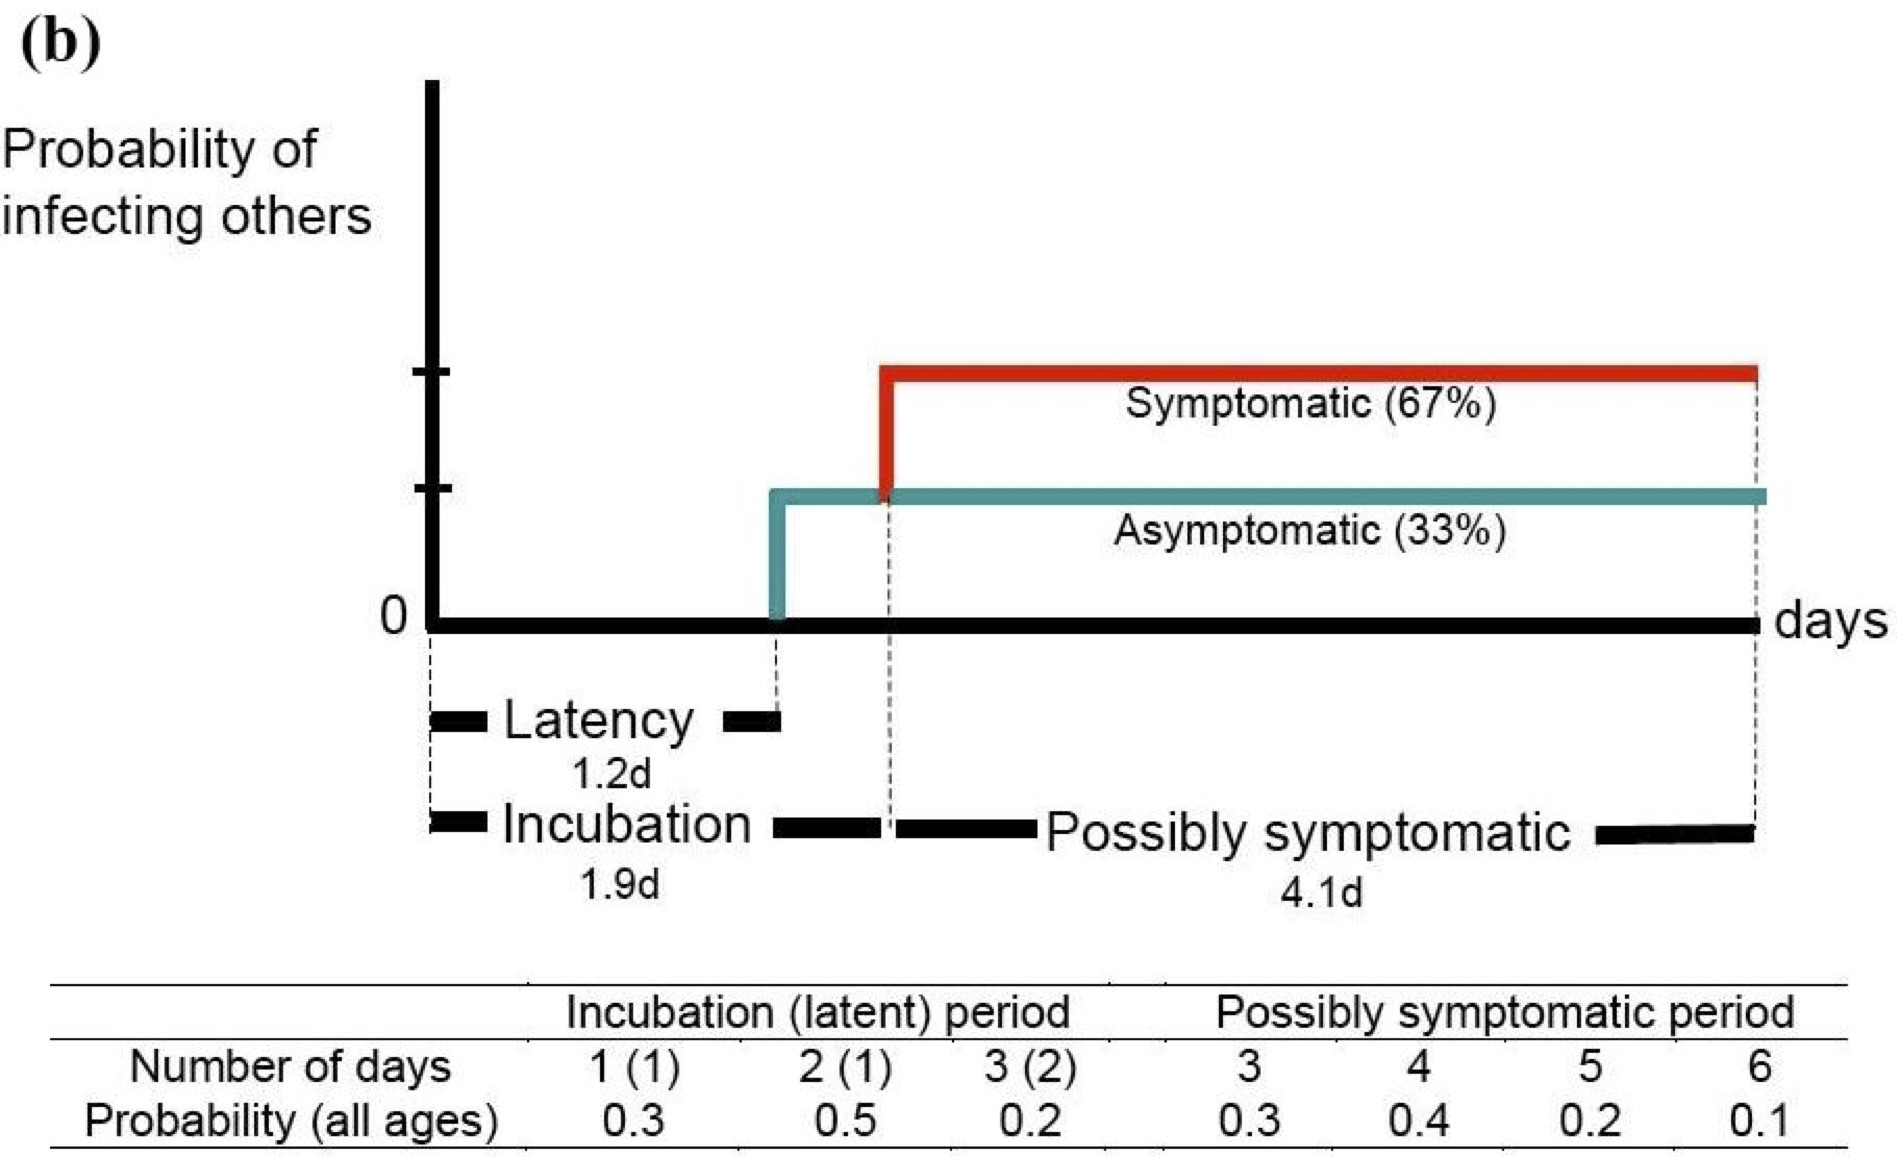

In [16]:
Image(filename=os.path.join('..', 'input', 'modelos_individuais',
                            'Germann_SupportingText_01266Fig3b.jpg'), width=800)

### VBI

- Ambos os trabalhos [Lewis (2011)](#Referências) e [Lewis et al (2013)](#Referências) fazem a mesma descrição:

> *Figure 1 illustrates the structure for the ILI disease model, which is an elaboration on the classic SEIR (Susceptible, Exposed, Infectious, and Recovered) model that accommodates multiple manifestations, asymptomatic infections, and a temporary Recovered state. The detailed disease model (see Additional file 1) used in the simulation includes a number of parameters taken from the literature to represent the broad spectrum of influenza-like illnesses*

(Figura 1 e arquivo adicional 1 nos próximos slides)

#### VBI: Figura 1

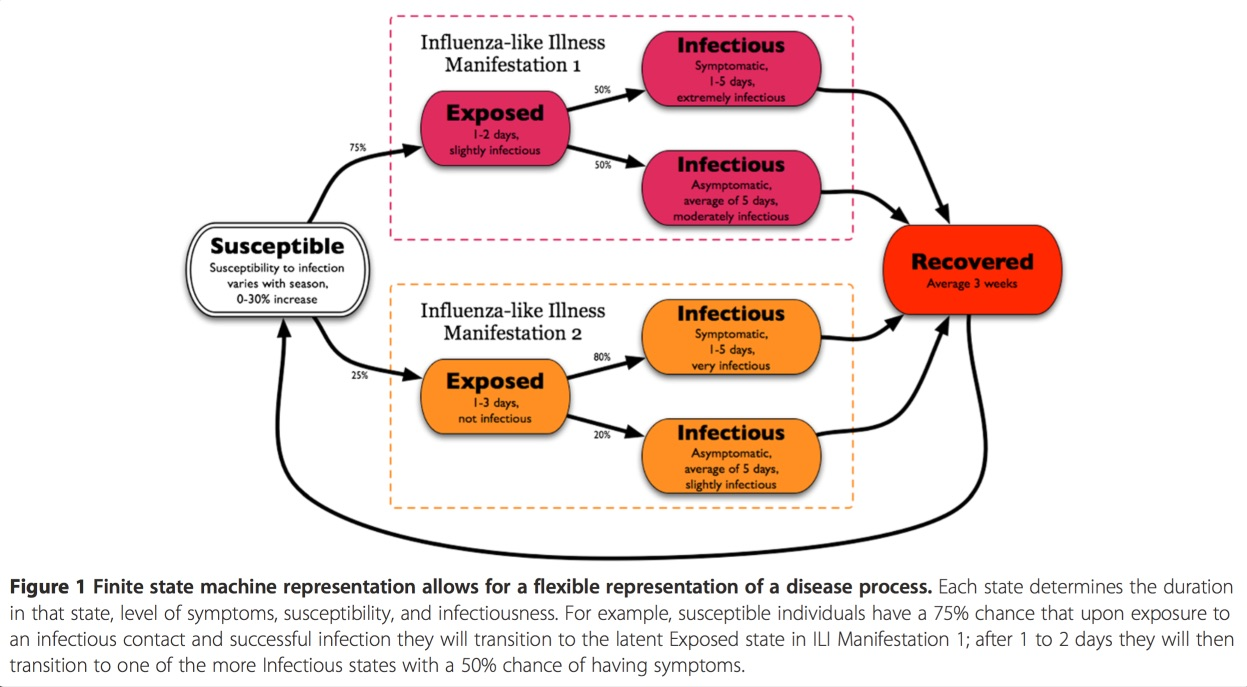

In [25]:
Image(filename=os.path.join('..', 'input', 'modelos_individuais', 'Lewis_et_al_EvaluationOutbreakDetectionwithSimulationModels_BMCMedicalInformaticsandDecisionMaking_2013_1472-6947-13-12_Fig1.jpg'), width=800)

#### VBI: arquivo adicional

> *Additional file 1: Detailed Disease Model: A state machine representation of the possible disease states in the simulation. Starting in the white block on the left an individual can move between different states of susceptibility (representing seasonal effects) over time, once infected they progress through an incubated infected stage into a symptomatic/asymptomatic infectious stage and then into recovered stages. Each state's susceptibility, relative infectiousness, and duration is specified.*

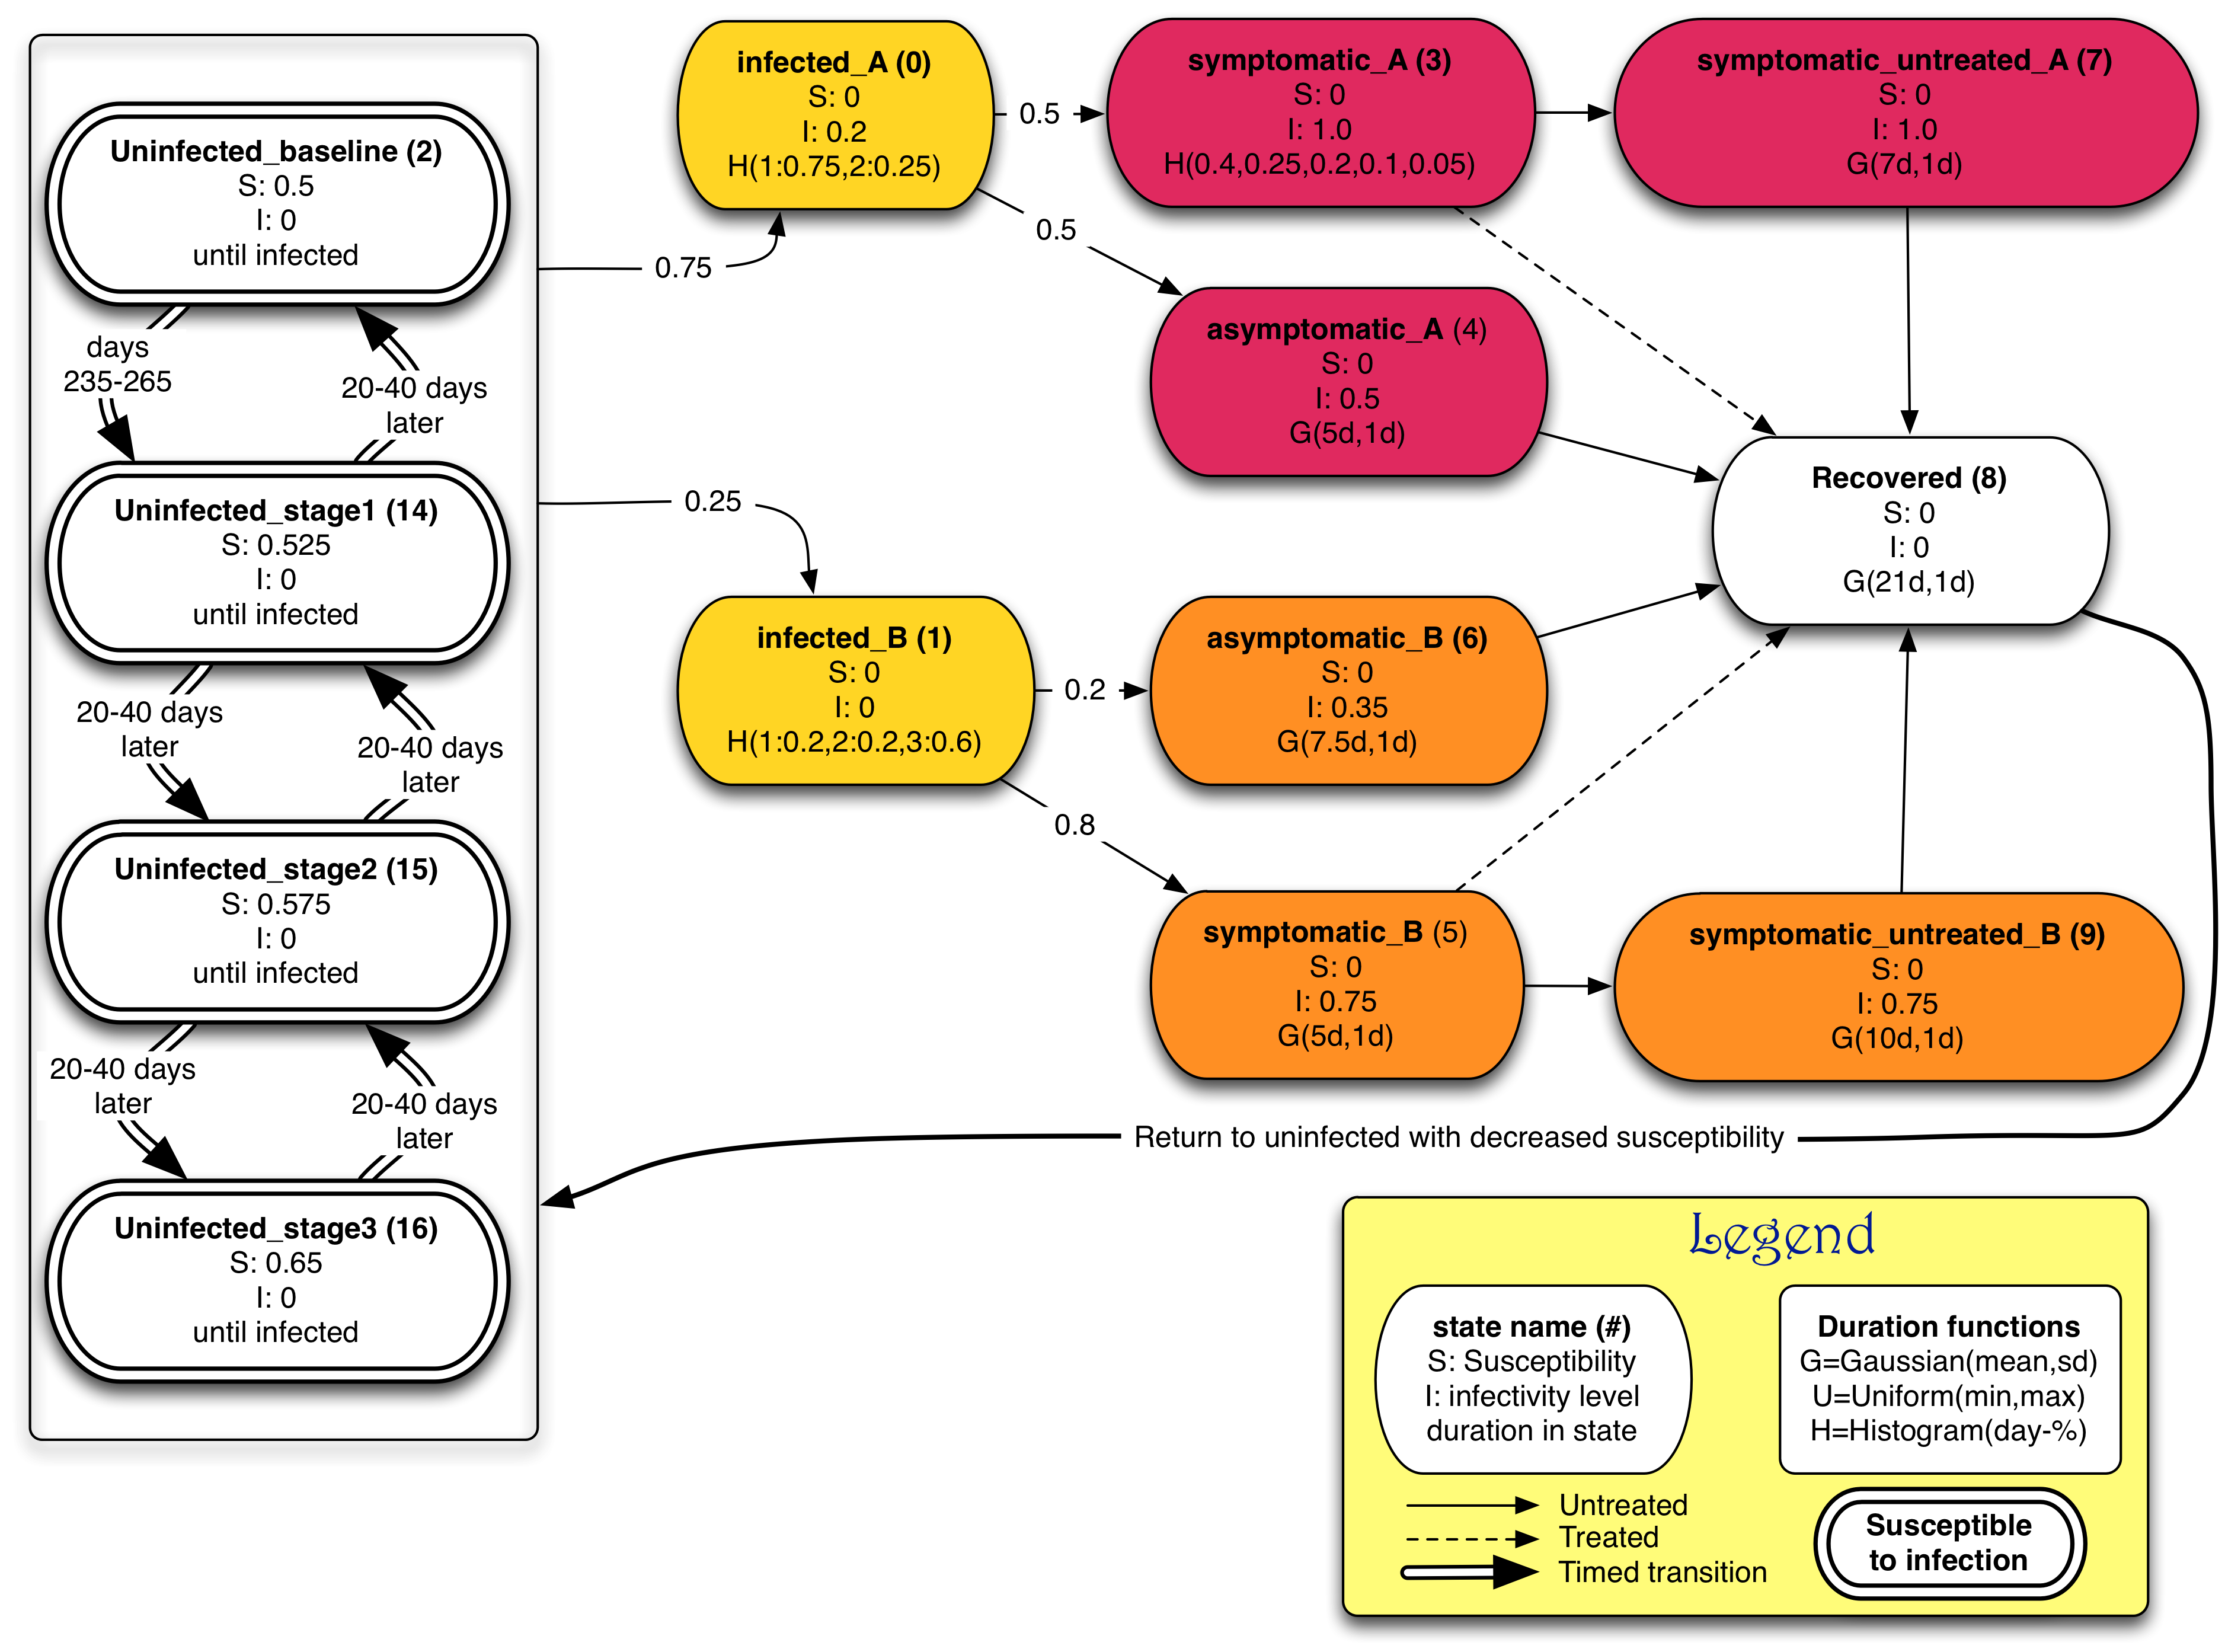

In [23]:
Image(filename=os.path.join('..', 'input', 'modelos_individuais', 'LewisEubankAbrams_2013_supplementary_infectious_process_diagram_12911_2012_684_MOESM1_ESM_Figure3.png'), width=700)

## Modulação da força de infecção

- **Imperial/Pitt** leva em consideração que a "carga viral" de cada paciente **varia com o tempo** e, baseado nisso, modula a força de infecção com um função ajustada de acordo com essa carga viral.

- **UW/LANL** e **VBL** consideram a força de infecção de cada indivíduo infectado como sendo **independente do tempo**.

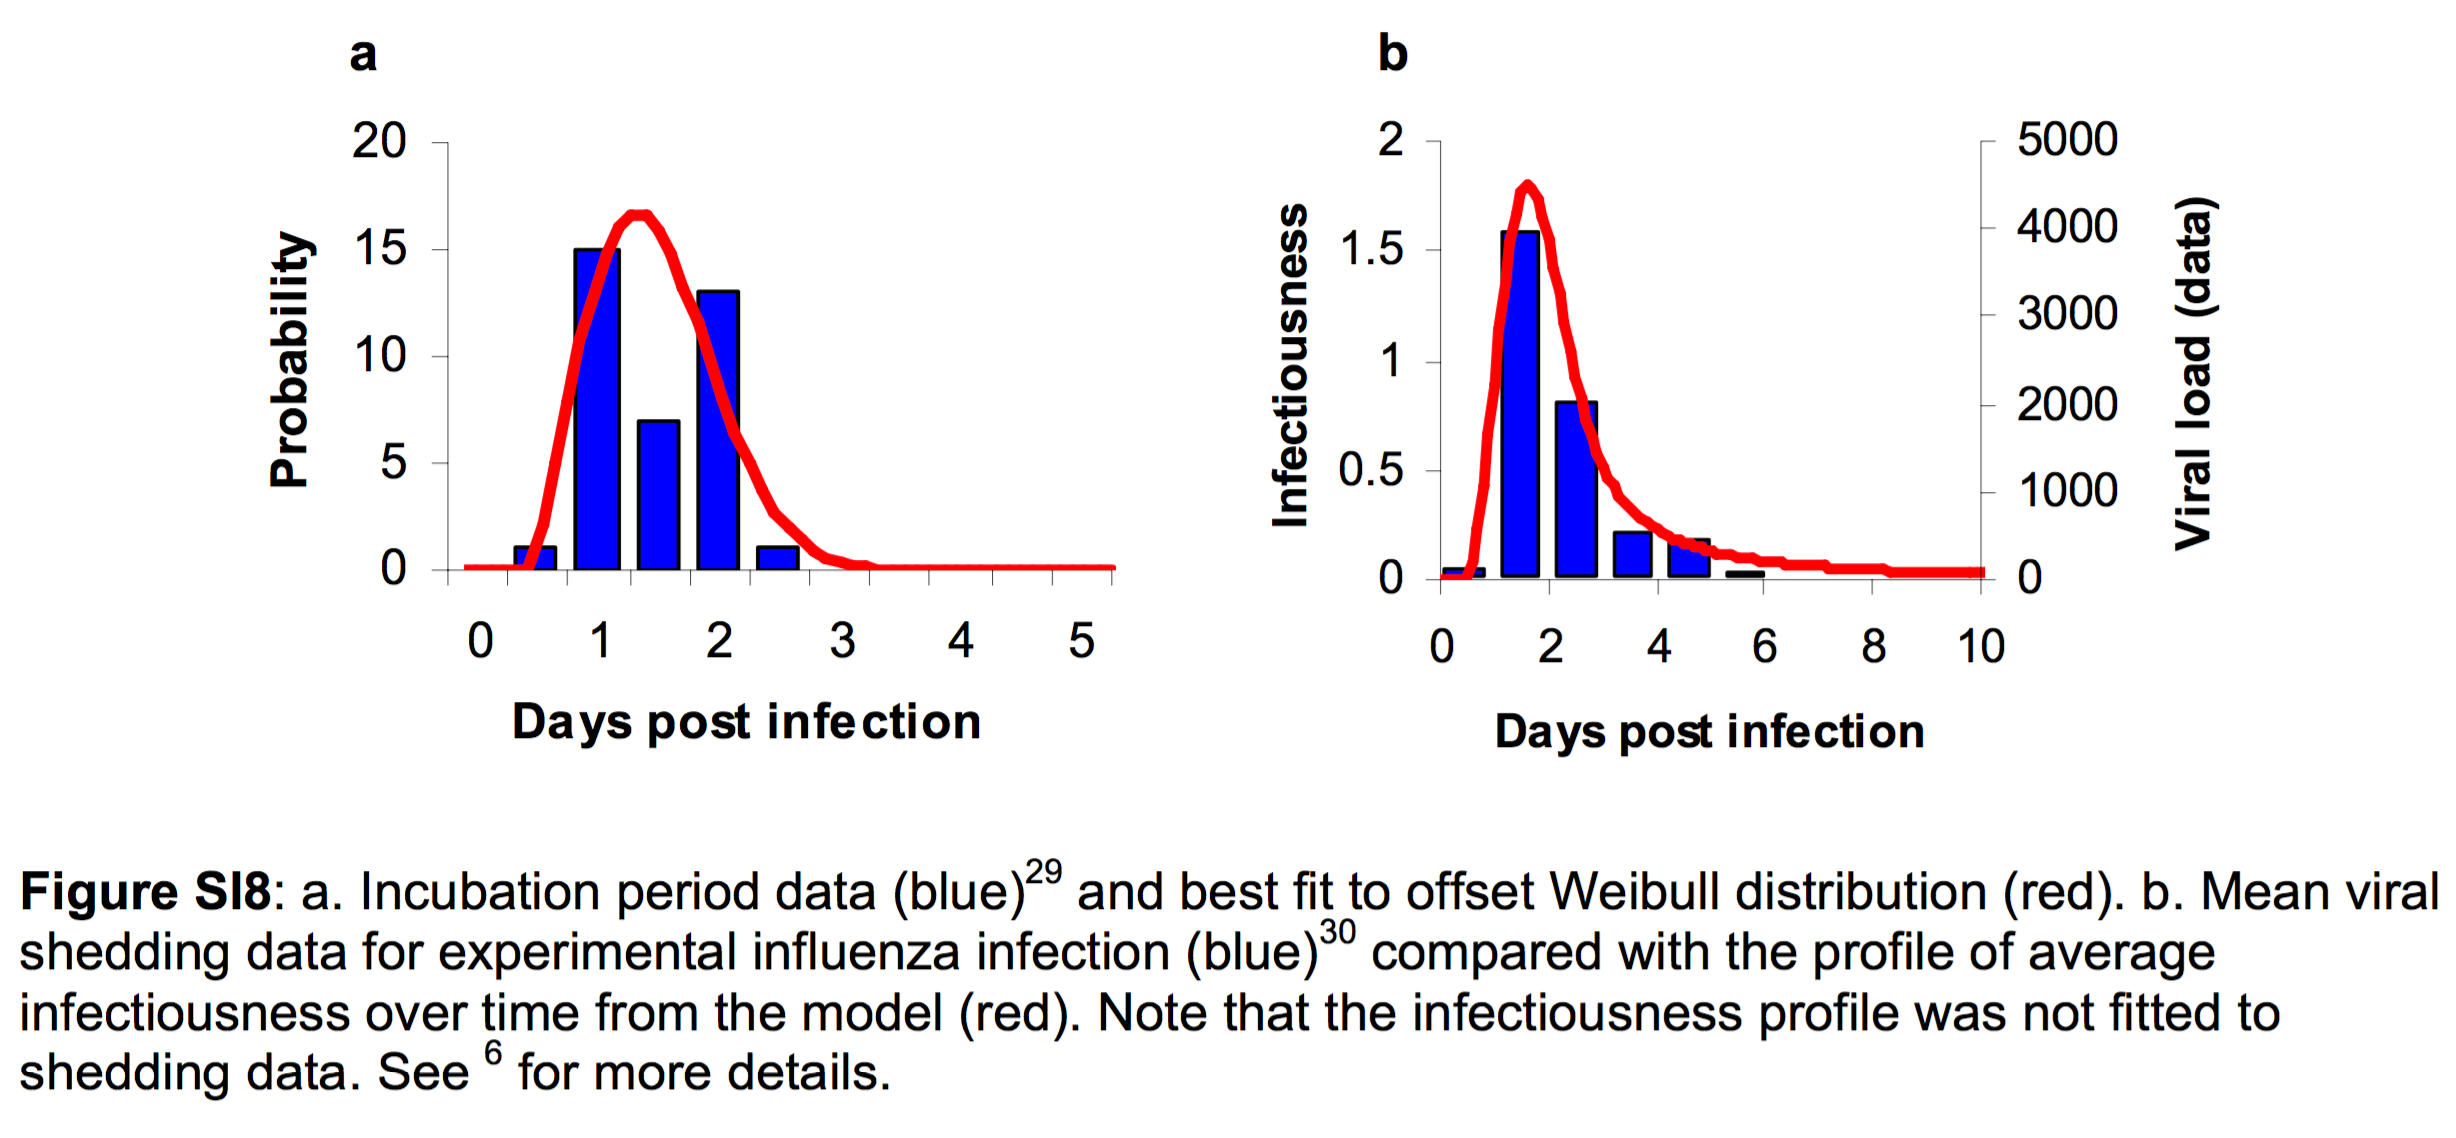

In [26]:
Image(filename=os.path.join('..', 'input', 'modelos_individuais',
                            '41586_2006_BFnature04795_MOESM28_ESM_FigureS18.png'), width=800)

### Proposta para o nosso modelo

No momento em que um indivíduo suscectível é infectado:

- Sorteamos se o indivíduo será sintomático ou assintomático através de um teste de Bernouilli com uma dada probabilidade $p_a$ de ser assintomático:

    - Escolha um número aletório entre 0 e 1 de uma distribuição uniforme no intervalo $0 \leq p < 1$ e obtemos assintomático, se $p<p_a$, ou sintomático, caso contrário.
    
    - Precisamos achar um valor razoável para $p_a$ (1/4? 1/3? 1/2?)

- Sorteamos o período de latência/incubação:

    - Usando a distribuição de Weibull, com os valores do Imperial College; ou
    
    - Usando uma distribuição log-normal ou alguma das outras (Gamma, Weibull ou Erlang) mencionadas no artigo [Lauer et al (2020)](#Referências).
    
- Sobre o período contagioso:

    - Ou fazemos como no Imperial College, fixando o período de infecção e usando uma função do tipo Weibull modulando a força de infecção;
    
    - Ou sorteamos o período infeccioso e mantemos a força de infecção constante, como feito nos outros modelos, mas com parâmetros adequados à covid-19.
    
    - Ou um misto dos dois, modulando a força de infecção mas fazendo o período de infecção ser sorteado de alguma forma.

## Número básico de reprodução

Por vir...

## Referências

- [Imperial College COVID-19 Response Team (16/mar/2020), Impact of non-pharmaceutical interventions (NPIs) to reduce COVID- 19 mortality and healthcare demand, 16 de março de 2020. (Free Download)](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf)

- [Ferguson NM, Cummings DAT, Fraser C, Cajka JC, Cooley PC, Burke DS (2006). Strategies for mitigating an influenza pandemic. Nature 442 (7101), 448–52 (Free Download)](https://pubmed.ncbi.nlm.nih.gov/16642006/); veja, também, as [notas suplementares](https://www.nature.com/articles/nature04795#Sec2).

- [Ferguson, N. M. et al. (2005), Strategies for containing an emerging influenza pandemic
in Southeast Asia, Nature 437, 209-214.](https://pubmed.ncbi.nlm.nih.gov/16079797/) (Link para download [aqui](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.452.235&rep=rep1&type=pdf) disponibilizado por [CiteSeerX](http://citeseerx.ist.psu.edu/); veja, também, as [notas suplementares](https://static-content.springer.com/esm/art%3A10.1038%2Fnature04017/MediaObjects/41586_2005_BFnature04017_MOESM1_ESM.pdf).

- [Germann TC, Kadau K, Longini IM, Macken CA (2006) Proc Natl Acad Sci USA 103:5935–
5940 (Free Download)](https://www.pnas.org/content/103/15/5935); veja, também, o [texto de apoio](https://www.pnas.org/content/pnas/suppl/2006/03/24/0601266103.DC1/01266SuppText.pdf) e as [figuras e informações](https://www.pnas.org/content/103/15/5935/tab-figures-data).

- [Halloran ME, Ferguson NM, Eubank S, et al (2008), Modeling targeted layered containment of an influenza pandemic in the United States. Proc Natl Acad Sci U S A 105 (12), 4639–44 (Free Download)](https://pubmed.ncbi.nlm.nih.gov/18332436/); veja, também, o [suplemento do artigo](https://www.pnas.org/content/suppl/2008/02/28/0706849105.DC1).

- [Lauer SA, Grantz KH, Bi Q, Jones FK, Zheng Q, Meredith HR, Azman AS, Reich NG, Lessler J (2020), Ann Intern Med.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7081172/)

- [Lewis, BL (2011), The Essential Role of Highly Detailed Simulations in Support of Public Health Decision-Making; Thesis dissertation at Virginia Polytechnic Institute and State University](https://vtechworks.lib.vt.edu/bitstream/handle/10919/26058/Lewis_BL_D_2011.pdf).

- [Lewis, B., Eubank, S., Abrams, A.M. et al. in silico Surveillance: evaluating outbreak detection with simulation models. BMC Med Inform Decis Mak 13, 12 (2013). https://doi.org/10.1186/1472-6947-13-12](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/1472-6947-13-12#citeas); veja também o [material eletrônico suplementar](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/1472-6947-13-12#Sec13).

- [Longini Jr  IM, Nizam A, Xu S, Ungchusak K, Hanshaoworakul W, Cummings DAT, Halloran ME (2005) Containing Pandemic Influenza at the Source, Science 309(5737): 1083-7](https://science.sciencemag.org/content/309/5737/1083); veja, também, o [material suplementar](https://science.sciencemag.org/content/suppl/2005/08/11/1115717.DC1).

<!--NAVIGATOR-->

---
[<- O cenário da cidade do Rio de Janeiro](20.00.Aula-Cenario_Rio.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 